# Percolation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
L = 200 # Size of grid
p = 0.6123 # Probability parameter

In [167]:
def generate_sample(length,prob):
    '''Function to generate a lattice sample'''
    grid = np.random.rand(length,length)
    return np.where(grid < prob, 1, 0)

In [4]:
latt = generate_sample(L,p)
latt

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 1, 1],
       [0, 1, 0, ..., 1, 1, 0]])

## Cluster Labeling: Hoshen-Kapelman algorithm

In [183]:
class Hoshen_Kapelman:
    ''' Implementation of the Hoshen-kapelman algorithm:
    length: Length of the lattice '''
    def __init__(self, length, lattice):
        self.length = length
        self.cluster_labels = np.zeros((self.length,self.length)) # Array to store the cluster labels
        self.lattice = lattice # Generated lattice
        self.pad_lattice = np.pad(self.lattice, 1, 'constant', constant_values = (0))
    
    def run(self):
        '''Hoshe-Kapelman Algorithm'''
        largest_label = 0 # Label name storage
        for i in range(1, self.pad_lattice.shape[0] - 1): #iterate over rows 
            for j in range(1, self.pad_lattice.shape[1] - 1): # iterate over columns
                if self.pad_lattice[i,j] == 1:  # If occupied
                    left = self.pad_lattice[i, j-1] 
                    upper = self.pad_lattice[i-1, j]
                    if left == 0 and upper == 0:  # left and upper neighbors conditions
                        largest_label += 1
                        self.cluster_labels[i-1,j-1] = largest_label
                    elif left == 1 and upper == 0:
                        self.cluster_labels[i-1,j-1] = self.cluster_labels[i-1,j-2]
                    elif left == 0 and upper == 1:
                        self.cluster_labels[i-1,j-1] = self.cluster_labels[i-2,j-1]
                    else:
                        if self.cluster_labels[i-2,j-1] != self.cluster_labels[i-1,j-2]:
                            min_label = min(self.cluster_labels[i-2,j-1], self.cluster_labels[i-1,j-2])
                            max_label = max(self.cluster_labels[i-2,j-1], self.cluster_labels[i-1,j-2])
                            self.cluster_labels[i-1,j-1] = min_label
                            self.cluster_labels = np.where(self.cluster_labels == max_label, min_label, self.cluster_labels)
                        else:
                            self.cluster_labels[i-1,j-1] = self.cluster_labels[i-2,j-1]
    
        if list(set(self.lattice.flatten())) == [1]:
            return self.lattice
        
        _, relabeled_clusters = np.unique(self.cluster_labels, return_inverse = True)  # relabel the clusters names 
        relabeled_clusters = relabeled_clusters.reshape((self.length,self.length)) 
        
        return relabeled_clusters

In [6]:
test = Hoshen_Kapelman(L, latt)
clusters = test.run()
clusters

array([[  1,   1,   1, ...,   0,   0,   0],
       [  1,   1,   1, ...,  12,  12,  12],
       [  1,   1,   0, ...,  12,  12,  12],
       ...,
       [910,   0, 980, ...,   0,   0,   0],
       [910,   0,   0, ..., 790, 790, 790],
       [  0, 988,   0, ..., 790, 790,   0]], dtype=int64)

In [7]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys

    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

Number of labels: 1006


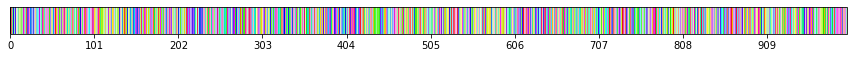

In [8]:
new_cmap = rand_cmap(len(list(set(clusters.flatten()))), type='bright', first_color_black=True, last_color_black=False, verbose=True)

In [9]:
len(list(set(clusters.flatten())))

1006

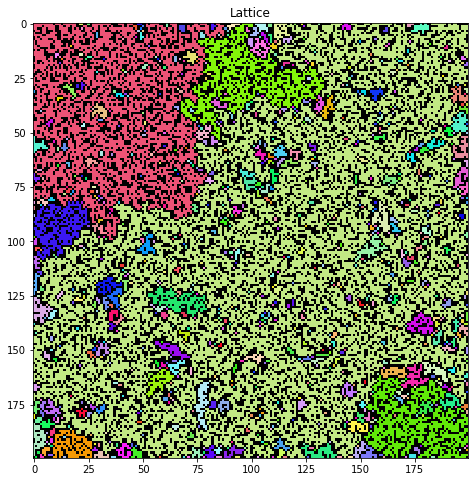

In [10]:
plt.figure(figsize = (8,8))
plt.imshow(clusters, cmap = new_cmap)
plt.title('Lattice')
plt.show()

In [11]:
probs = [0.1, 0.2, 0.3, 0.5, 0.58, 0.6, 0.61, 0.8, 0.9] # probabilities

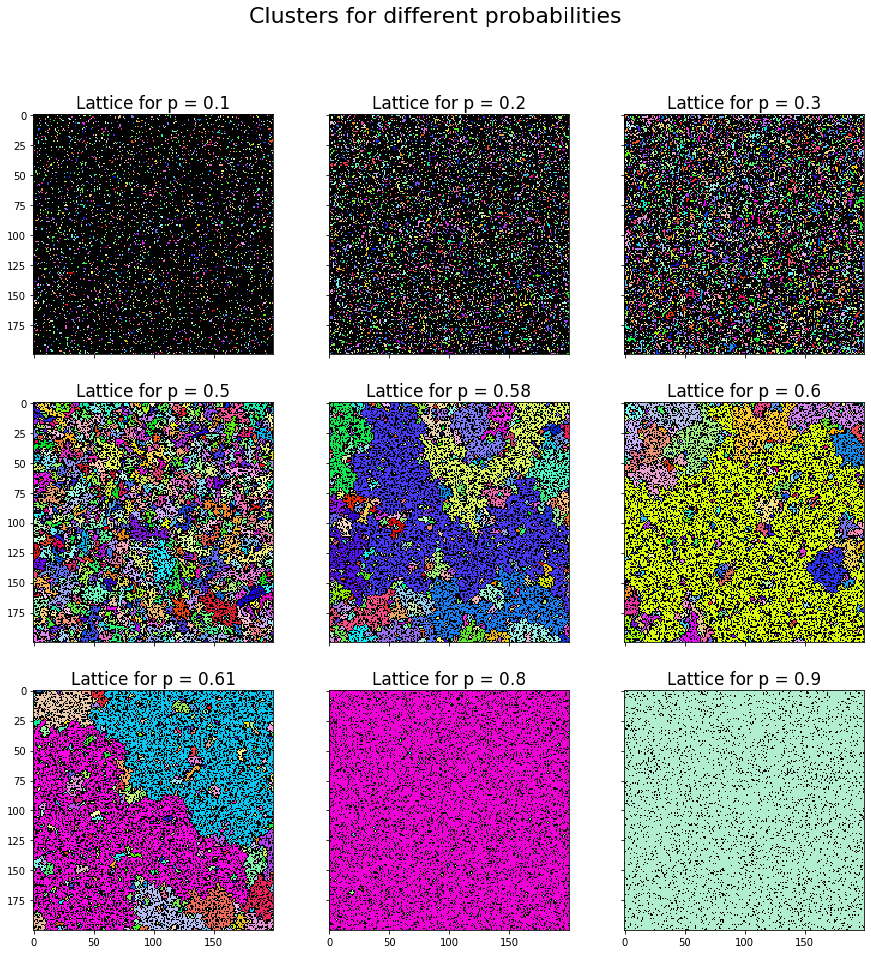

In [12]:
### Create plots of the distribution function at different times

fig, ax = plt.subplots(3, 3,figsize=(15,15))
fig.suptitle('Clusters for different probabilities',fontsize = 22) # general title

ti = 0 # index counter
images = [] # list to store images

for i in range(3): 
    for j in range(3):
        lattice = generate_sample(L,probs[ti])
        clusters_group = Hoshen_Kapelman(L, lattice).run()
        new_cmap = rand_cmap(len(list(set(clusters_group.flatten()))), type='bright',
                             first_color_black=True, last_color_black=False, verbose=False)
        cp = ax[i,j].imshow(clusters_group, cmap = new_cmap)
        ax[i,j].set_title(f'Lattice for p = {probs[ti]}',fontsize = 17) # create title
        images.append(cp) # save contour in list
        ti+=1 

# Hide x labels and tick labels for top plots and y ticks for right plots.
for axx in ax.flat:
    axx.label_outer()

## Montecarlo simulations:

Generate M samples for each probability p and extract the mean observables

### Number of clusters per sample

In [205]:
M_samples = 100 # Number of samples generated for each probability p
probability_values = np.linspace(0,1,100)
L = 50 # Length of lattice

In [206]:
start = time.time()
mean_cluster_sizes = []
for pval in probability_values:
    clusters_sizes = []
    for j in range(M_samples):
        lattice = generate_sample(L, pval)
        clusters_group = Hoshen_Kapelman(L,lattice).run()
        clusters_etiquette = list(set(clusters_group.flatten()))[1:-1]
        clusters_sizes.append(len(clusters_etiquette))
    mean_cluster_sizes.append(np.array(clusters_sizes).mean())
end = time.time()
print('Time: ',(end-start)/60)

Time:  0.49894008636474607


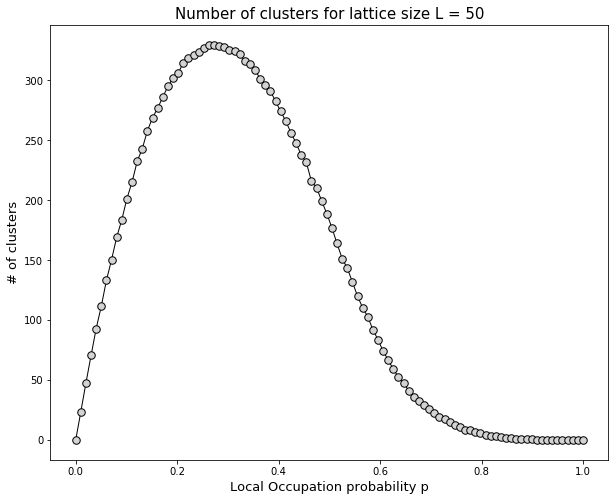

In [216]:
fig,ax = plt.subplots(figsize = (10,8))
ax.set_xlabel('Local Occupation probability p',fontsize = 13)
ax.set_ylabel('# of clusters',fontsize = 13)
ax.plot(probability_values, mean_cluster_sizes, 'o-k',linewidth=1, markersize=7.5, markerfacecolor = 'lightgray',
           markeredgecolor = 'k', markeredgewidth = 1)
ax.set_title(f'Number of clusters for lattice size L = {L}', fontsize = 15)
plt.show()

### Percolation Probability

In [218]:
def percolating_cluster(labeled_lattice):
    ''' Function determines if a given lattice has a percolating cluster 
    Input:
    - lattice with cluster labels'''
    
    first_row_elements = np.array(list(set(labeled_lattice[0])))
    first_col_elements = np.array(list(set(labeled_lattice[:,0])))
    
    last_row_elements = np.array(list(set(labeled_lattice[-1])))
    last_col_elements = np.array(list(set(labeled_lattice[:,-1])))
    
    # Intersection of the first and last row and columns
    intersection_rows = np.intersect1d(first_row_elements, last_row_elements)
    intersection_cols = np.intersect1d(first_col_elements, last_col_elements)
    
    # Verificate the rows
    if intersection_rows.size > 0: # verify if intersection array is not empty
        if 0 in intersection_rows: # Verify if 0 (empty site) 
            intersection_rows = intersection_rows.tolist()
            intersection_rows.remove(0)
            if np.array(intersection_rows).size > 0: return [True,'row'] # Verify if there is an intersection
        else: return [True,'row']

    # Verificate the rows
    if intersection_cols.size > 0: # verify if intersection array is not empty
        if 0 in intersection_cols: # Verify if 0 (empty site) 
            intersection_cols = intersection_cols.tolist()
            intersection_cols.remove(0)
            if np.array(intersection_cols).size > 0: return [True,'col'] # Verify if there is an intersection
        else: return [True,'col']
        
    return [False,'none']

In [221]:
start = time.time()
percolating_probs = []
for pval in probability_values:
    percolating_clusters = 0
    for i in range(M_samples):
        lattice = generate_sample(L,pval)
        lattice_labels = Hoshen_Kapelman(L, lattice).run()
        boolean_val = percolating_cluster(lattice_labels)[0]
        if boolean_val:
            percolating_clusters += 1
    percolating_probs.append(percolating_clusters/M_samples)
end = time.time()
print('Time: ',(end-start)/60)

Time:  0.5228849331537883


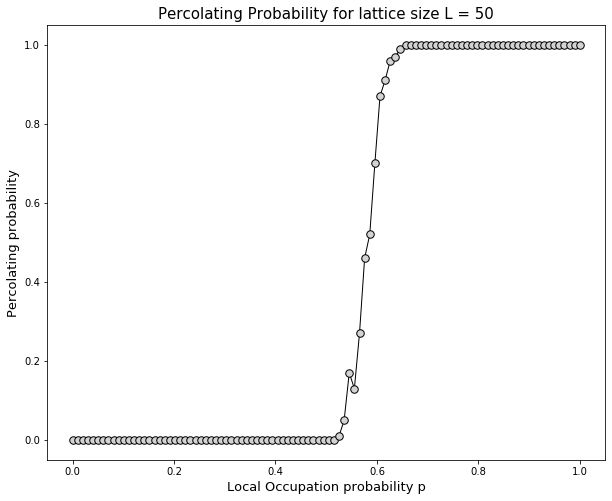

In [222]:
fig,ax = plt.subplots(figsize = (10,8))
ax.set_xlabel('Local Occupation probability p',fontsize = 13)
ax.set_ylabel('Percolating probability',fontsize = 13)
ax.plot(probability_values, percolating_probs, 'o-k',linewidth=1, markersize=7.5, markerfacecolor = 'lightgray',
           markeredgecolor = 'k', markeredgewidth = 1)
ax.set_title(f'Percolating Probability for lattice size L = {L}', fontsize = 15)
plt.show()

In [212]:
start = time.time()
L_vals = [8, 16, 32, 64, 128, 256]
solutions_probs = np.zeros((len(L_vals),len(probability_values)))

for idx,L_val in enumerate(L_vals):
    percolate_probs = []
    for pval in probability_values:
        percolating_clusters = 0
        for i in range(M_samples):
            lattice = generate_sample(L_val,pval)
            lattice_labels = Hoshen_Kapelman(L_val, lattice).run()
            boolean_val = percolating_cluster(lattice_labels)[0]
            if boolean_val:
                percolating_clusters += 1
        percolate_probs.append(percolating_clusters/M_samples)
    solutions_probs[idx] = np.array(percolate_probs)
    
end = time.time()
print('Time: ',(end-start)/60)

Time:  35.683315229415896


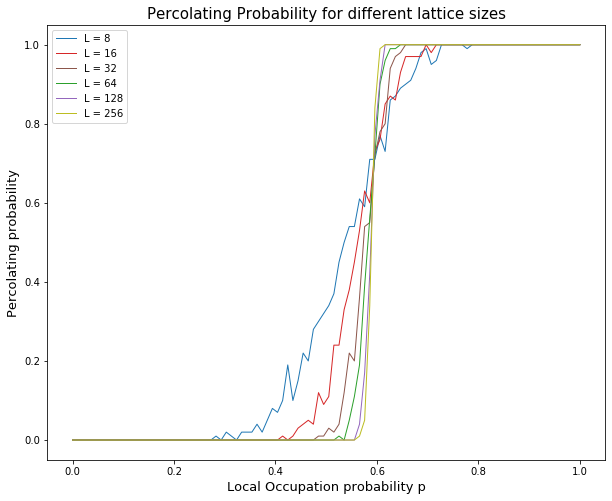

In [217]:
fig,ax = plt.subplots(figsize = (10,8))
ax.set_xlabel('Local Occupation probability p',fontsize = 13)
ax.set_ylabel('Percolating probability',fontsize = 13)

colors = ['tab:blue','tab:red','tab:brown','tab:green','tab:purple','tab:olive']
for idx,sol in enumerate(solutions_probs):
    ax.plot(probability_values, sol, '-k',linewidth=1, color = colors[idx], markeredgewidth = 1,
           label = f'L = {L_vals[idx]}')

ax.set_title(f'Percolating Probability for different lattice sizes', fontsize = 15)
ax.legend()
plt.show()

### Cluster Strength

In [251]:
def extract_percolating_cluster(labeled_lattice, row_or_col):
    ''' Function determines that determines the percolating cluster size
    Input:
    - lattice with cluster labels
    - row_or_col: string indicating if the percolating cluster is in the rows or columns'''

    if row_or_col == 'row':
        first_row_elements = np.array(list(set(labeled_lattice[0])))
        last_row_elements = np.array(list(set(labeled_lattice[-1])))
        intersection_rows = np.intersect1d(first_row_elements, last_row_elements) # Intersection of the first and last row
        if 0 in intersection_rows: # Verify if 0 (empty site) 
            intersection_rows = intersection_rows.tolist()
            intersection_rows.remove(0)
            label = intersection_rows[0]
            percolating_cluster_size = list(labeled_lattice.flatten()).count(label)
        else:
            label = intersection_rows[0]
            percolating_cluster_size = list(labeled_lattice.flatten()).count(label)
    
    elif row_or_col == 'col':
        first_col_elements = np.array(list(set(labeled_lattice[:,0])))
        last_col_elements = np.array(list(set(labeled_lattice[:,-1])))
        intersection_cols = np.intersect1d(first_col_elements, last_col_elements) # Intersection of the first and last columns
        if 0 in intersection_cols: # Verify if 0 (empty site) 
            intersection_cols = intersection_cols.tolist()
            intersection_cols.remove(0)
            label = intersection_cols[0]
            percolating_cluster_size = list(labeled_lattice.flatten()).count(label)
        else:
            label = intersection_cols[0]
            percolating_cluster_size = list(labeled_lattice.flatten()).count(label)
    else:
        raise('No specified input parameters')
        
    return percolating_cluster_size

In [252]:
L = 25

In [253]:
start = time.time()
percolating_strength = []
for pval in probability_values:
    strength_probs = []
    for i in range(M_samples):
        lattice = generate_sample(L,pval)
        lattice_labels = Hoshen_Kapelman(L, lattice).run()
        percolate_cl = percolating_cluster(lattice_labels)
        if percolate_cl[0] == True:
            strength_probs.append(extract_percolating_cluster(lattice_labels,percolate_cl[1])/(L*L))
        elif percolate_cl[0] == False:
            strength_probs.append(0)
            
    percolating_strength.append(np.array(strength_probs).mean())
end = time.time()
print('Time: ',(end-start)/60)

Time:  0.1482706904411316


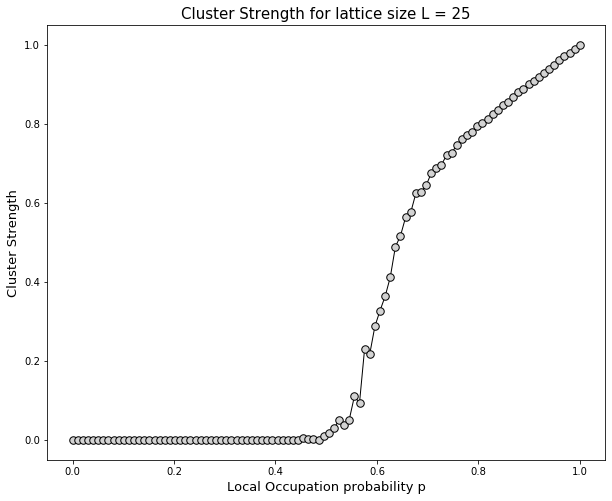

In [254]:
fig,ax = plt.subplots(figsize = (10,8))
ax.set_xlabel('Local Occupation probability p',fontsize = 13)
ax.set_ylabel('Cluster Strength',fontsize = 13)
ax.plot(probability_values, percolating_strength, 'o-k',linewidth=1, markersize=7.5, markerfacecolor = 'lightgray',
           markeredgecolor = 'k', markeredgewidth = 1)
ax.set_title(f'Cluster Strength for lattice size L = {L}', fontsize = 15)
plt.show()

In [257]:
start = time.time()
solution_strengths = np.zeros((len(L_vals),len(probability_values)))

for idx,L_val in enumerate(L_vals):
    percolating_strength = []
    for pval in probability_values:
        strength_probs = []
        for i in range(M_samples):
            lattice = generate_sample(L_val,pval)
            lattice_labels = Hoshen_Kapelman(L_val, lattice).run()
            percolate_cl = percolating_cluster(lattice_labels)
            if percolate_cl[0] == True:
                strength_probs.append(extract_percolating_cluster(lattice_labels,percolate_cl[1])/(L_val*L_val))
            elif percolate_cl[0] == False:
                strength_probs.append(0)          
        percolating_strength.append(np.array(strength_probs).mean())
    solution_strengths[idx] = np.array(percolating_strength)
    
end = time.time()
print('Time: ',(end-start)/60)

Time:  38.832660055160524


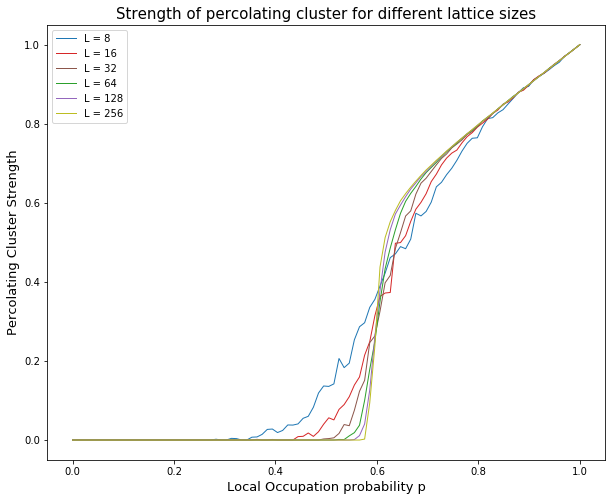

In [258]:
fig,ax = plt.subplots(figsize = (10,8))
ax.set_xlabel('Local Occupation probability p',fontsize = 13)
ax.set_ylabel('Percolating Cluster Strength',fontsize = 13)

colors = ['tab:blue','tab:red','tab:brown','tab:green','tab:purple','tab:olive']
for idx,sol in enumerate(solution_strengths):
    ax.plot(probability_values, sol, '-k',linewidth=1, color = colors[idx], markeredgewidth = 1,
           label = f'L = {L_vals[idx]}')

ax.set_title(f'Strength of percolating cluster for different lattice sizes', fontsize = 15)
ax.legend()
plt.show()

### Average cluster size per sample 

In [16]:
# average_sizes = []
# for pval in probability_values[1:]:
#     sizes_mean = []
#     for j in range(M_samples):
#         lattice = generate_sample(L,pval)
#         clusters_group = Hoshen_Kapelman(L, lattice).run()
#         clusters_etiquette = list(set(clusters_group.flatten()))[1:-1]
# #         print(clusters_etiquette)
#         sizes = np.array([list(clusters_group.flatten()).count(cluster_et) for cluster_et in clusters_etiquette])
# #         print(sizes)
        
# #         break
# #     break
        
#         sizes_mean.append(sizes.mean())
#     average_sizes.append(np.array(sizes_mean).mean())

C:\Users\erik_\Downloads\Anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
C:\Users\erik_\Downloads\Anaconda\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
# len(probability_values)

100

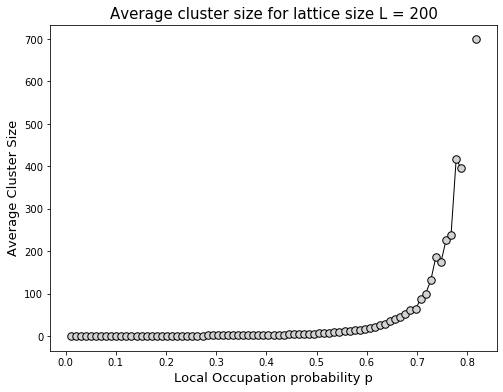

In [21]:
# fig,ax = plt.subplots(figsize = (8,6))
# ax.set_xlabel('Local Occupation probability p',fontsize = 13)
# ax.set_ylabel('Average Cluster Size',fontsize = 13)
# ax.plot(probability_values[1:], average_sizes, 'o-k',linewidth=1, markersize=7.5, markerfacecolor = 'lightgray',
#            markeredgecolor = 'k', markeredgewidth = 1)
# ax.set_title('Average cluster size for lattice size L = 200', fontsize = 15)
# plt.show()